# Task 2

---

## Predictive modeling of customer bookings

This Jupyter notebook includes some code to get you started with this predictive modeling task. We will use various packages for data manipulation, feature engineering and machine learning.

### Exploratory data analysis

First, we must explore the data in order to better understand what we have and the statistical properties of the dataset.

# load libraries

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

# load Data

In [62]:
df = pd.read_csv(r"/content/customer_booking.csv", encoding="ISO-8859-1")
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


# Data exploration

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

The `.head()` method allows us to view the first 5 rows in the dataset, this is useful for visual inspection of our columns

The `.info()` method gives us a data description, telling us the names of the columns, their data types and how many null values we have. Fortunately, we have no null values. It looks like some of these columns should be converted into different data types, e.g. flight_day.

To provide more context, below is a more detailed data description, explaining exactly what each column means:

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking

Before we compute any statistics on the data, lets do any necessary data conversion

In [64]:
df["flight_day"].unique()

array(['Sat', 'Wed', 'Thu', 'Mon', 'Sun', 'Tue', 'Fri'], dtype=object)

In [65]:
mapping = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}

df["flight_day"] = df["flight_day"].map(mapping)

In [66]:
df["flight_day"].unique()

array([6, 3, 4, 1, 7, 2, 5])

In [67]:
df.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,84.940480,23.04456,9.06634,3.814420,0.668780,0.296960,0.427140,7.277561,0.149560
std,1.020165,90.451378,33.88767,5.41266,1.992792,0.470657,0.456923,0.494668,1.496863,0.356643
min,1.000000,0.000000,0.00000,0.00000,1.000000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.000000,21.000000,5.00000,5.00000,2.000000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.000000,51.000000,17.00000,9.00000,4.000000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,2.000000,115.000000,28.00000,13.00000,5.000000,1.000000,1.000000,1.000000,8.830000,0.000000
max,9.000000,867.000000,778.00000,23.00000,7.000000,1.000000,1.000000,1.000000,9.500000,1.000000


The `.describe()` method gives us a summary of descriptive statistics over the entire dataset (only works for numeric columns). This gives us a quick overview of a few things such as the mean, min, max and overall distribution of each column.

From this point, you should continue exploring the dataset with some visualisations and other metrics that you think may be useful. Then, you should prepare your dataset for predictive modelling. Finally, you should train your machine learning model, evaluate it with performance metrics and output visualisations for the contributing variables. All of this analysis should be summarised in your single slide.

In [68]:
df.tail()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
49995,2,Internet,RoundTrip,27,6,9,6,PERPNH,Australia,1,0,1,5.62,0
49996,1,Internet,RoundTrip,111,6,4,7,PERPNH,Australia,0,0,0,5.62,0
49997,1,Internet,RoundTrip,24,6,22,6,PERPNH,Australia,0,0,1,5.62,0
49998,1,Internet,RoundTrip,15,6,11,1,PERPNH,Australia,1,0,1,5.62,0
49999,1,Internet,RoundTrip,19,6,10,4,PERPNH,Australia,0,1,0,5.62,0


In [69]:
df.sample(5)

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
8623,1,Internet,RoundTrip,32,28,10,3,DELPNH,Cambodia,1,1,1,5.52,0
33333,1,Internet,RoundTrip,15,4,8,6,KCHTPE,Malaysia,1,0,0,4.67,0
47579,1,Internet,RoundTrip,35,6,8,5,ICNSYD,Australia,1,0,1,8.58,0
13773,1,Internet,RoundTrip,27,18,6,4,ICNMEL,South Korea,1,0,1,8.83,0
17154,2,Internet,RoundTrip,184,41,14,2,KNOTPE,Taiwan,0,0,0,4.67,0


In [70]:
df.shape

(50000, 14)

In [71]:
df.isnull()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,False,False,False,False,False,False,False,False,False,False,False,False,False,False
49996,False,False,False,False,False,False,False,False,False,False,False,False,False,False
49997,False,False,False,False,False,False,False,False,False,False,False,False,False,False
49998,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [72]:
df.isnull().sum()

,0
num_passengers,0
sales_channel,0
trip_type,0
purchase_lead,0
length_of_stay,0
flight_hour,0
flight_day,0
route,0
booking_origin,0
wants_extra_baggage,0


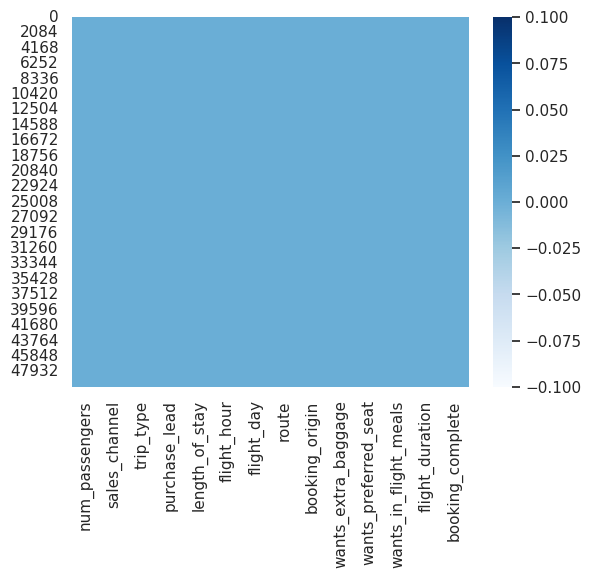

In [73]:
sns.heatmap(df.isnull(),cmap = "Blues")
plt.show()

In [74]:
df.duplicated()

,0
0,False
1,False
2,False
3,False
4,False
...,...
49995,False
49996,False
49997,False
49998,False


In [75]:
df.duplicated().sum()

np.int64(719)

In [76]:
df.drop_duplicates(inplace = True)

In [77]:
df.duplicated().sum()

np.int64(0)

# Data Analysis

In [78]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

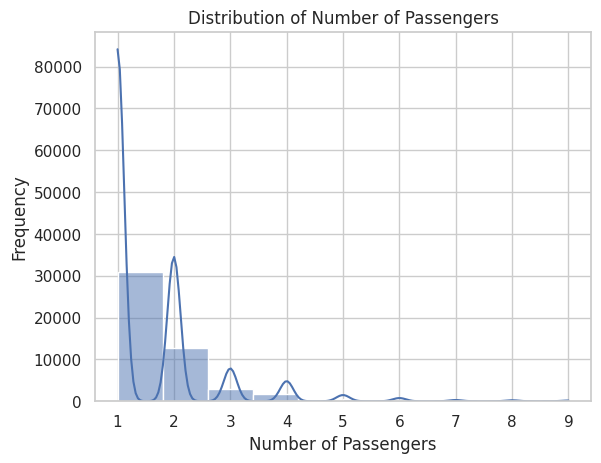

In [79]:
sns.histplot(df['num_passengers'], bins=10, kde=True)
plt.title('Distribution of Number of Passengers')
plt.xlabel('Number of Passengers')
plt.ylabel('Frequency')
plt.show()

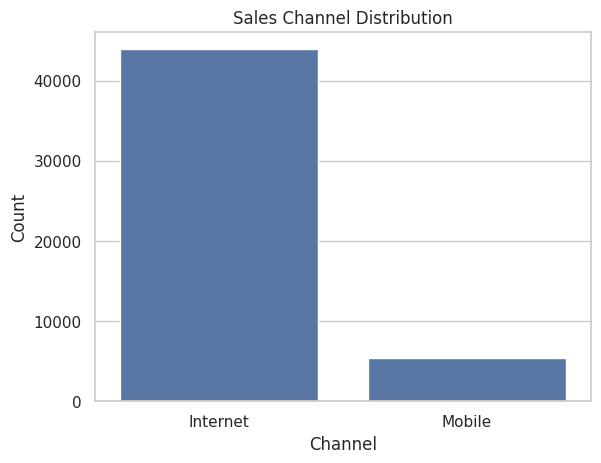

In [80]:
sns.countplot(x='sales_channel', data=df)
plt.title('Sales Channel Distribution')
plt.xlabel('Channel')
plt.ylabel('Count')
plt.show()

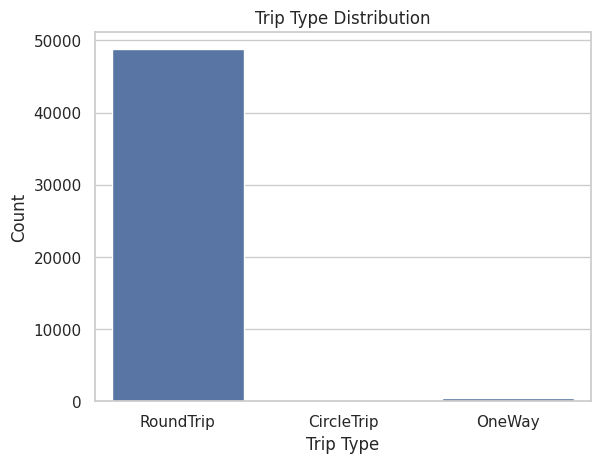

In [81]:
sns.countplot(x='trip_type', data=df)
plt.title('Trip Type Distribution')
plt.xlabel('Trip Type')
plt.ylabel('Count')
plt.show()

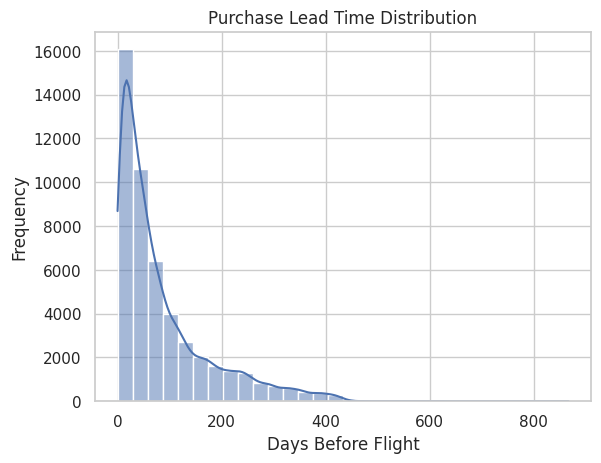

In [82]:
sns.histplot(df['purchase_lead'], bins=30, kde=True)
plt.title('Purchase Lead Time Distribution')
plt.xlabel('Days Before Flight')
plt.ylabel('Frequency')
plt.show()

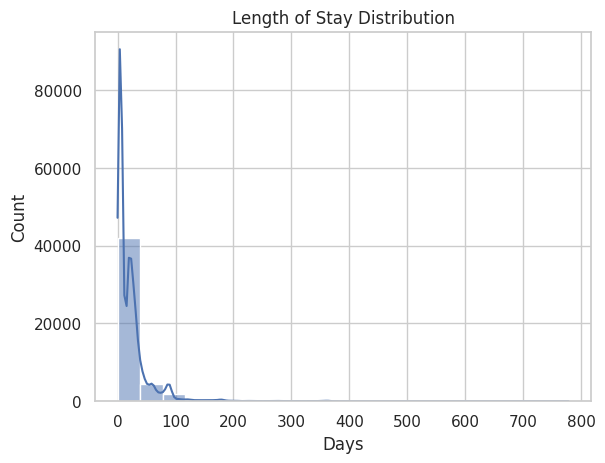

In [83]:
sns.histplot(df['length_of_stay'], bins=20, kde=True)
plt.title('Length of Stay Distribution')
plt.xlabel('Days')
plt.ylabel('Count')
plt.show()

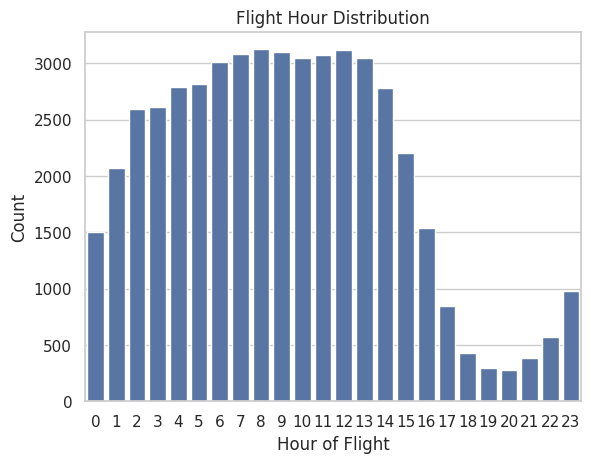

In [84]:
sns.countplot(x='flight_hour', data=df)
plt.title('Flight Hour Distribution')
plt.xlabel('Hour of Flight')
plt.ylabel('Count')
plt.show()

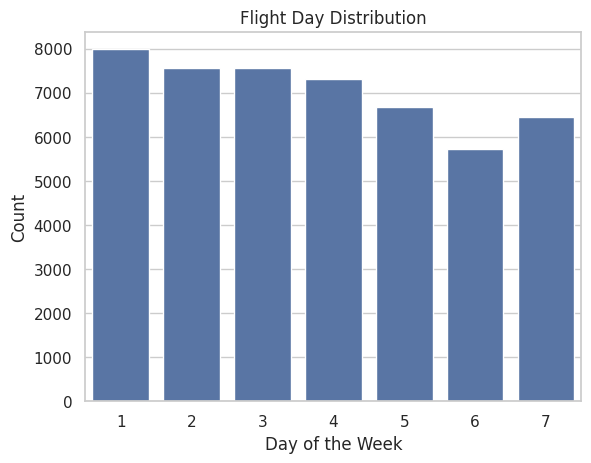

In [85]:
sns.countplot(x='flight_day', data=df)
plt.title('Flight Day Distribution')
plt.xlabel('Day of the Week')
plt.ylabel('Count')
plt.show()

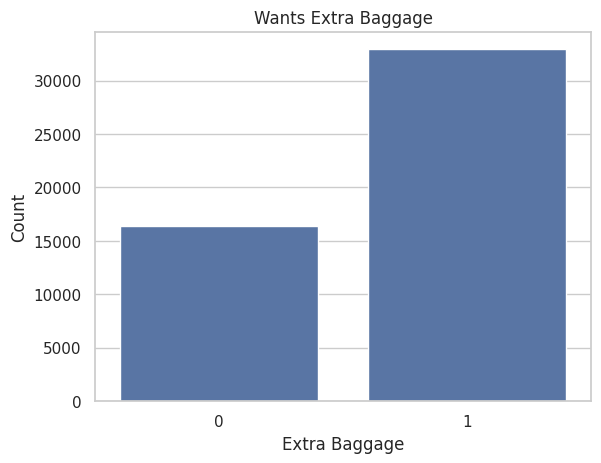

In [86]:
sns.countplot(x='wants_extra_baggage', data=df)
plt.title('Wants Extra Baggage')
plt.xlabel('Extra Baggage')
plt.ylabel('Count')
plt.show()

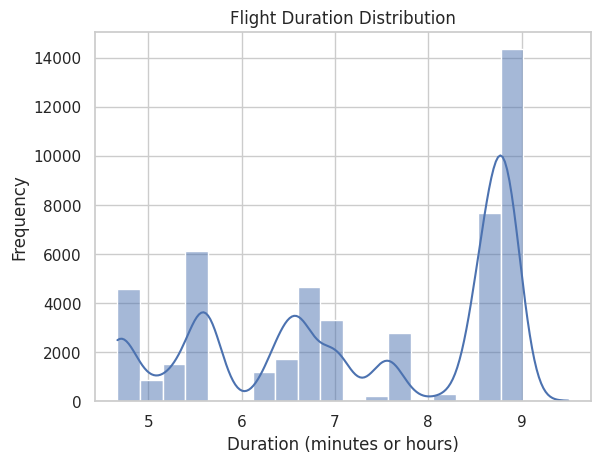

In [87]:
sns.histplot(df['flight_duration'], bins=20, kde=True)
plt.title('Flight Duration Distribution')
plt.xlabel('Duration (minutes or hours)')
plt.ylabel('Frequency')
plt.show()

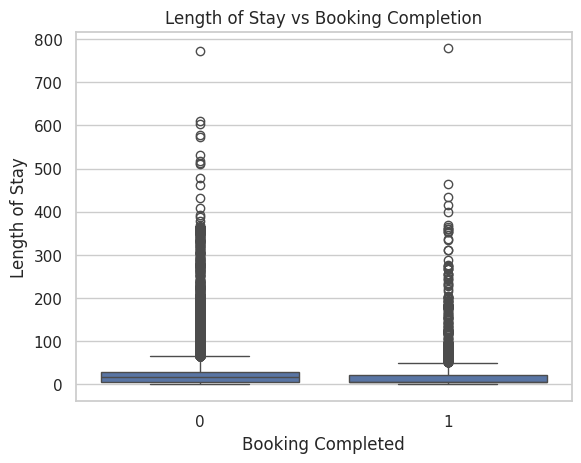

In [88]:
sns.boxplot(x='booking_complete', y='length_of_stay', data=df)
plt.title('Length of Stay vs Booking Completion')
plt.xlabel('Booking Completed')
plt.ylabel('Length of Stay')
plt.show()

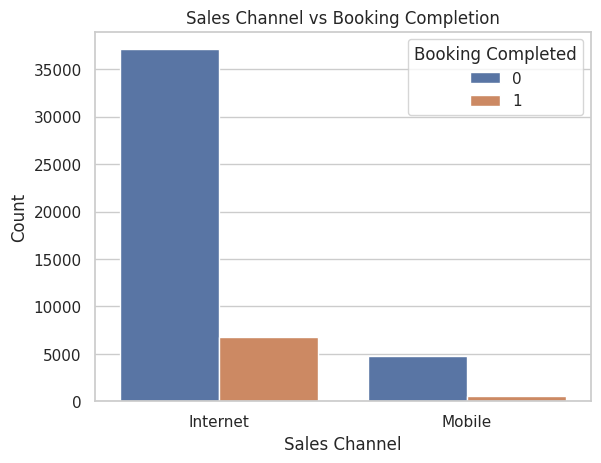

In [89]:
sns.countplot(x='sales_channel', hue='booking_complete', data=df)
plt.title('Sales Channel vs Booking Completion')
plt.xlabel('Sales Channel')
plt.ylabel('Count')
plt.legend(title='Booking Completed')
plt.show()

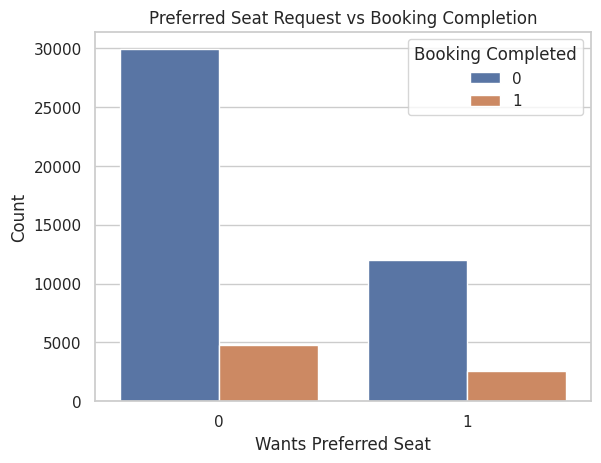

In [90]:
sns.countplot(x='wants_preferred_seat', hue='booking_complete', data=df)
plt.title('Preferred Seat Request vs Booking Completion')
plt.xlabel('Wants Preferred Seat')
plt.ylabel('Count')
plt.legend(title='Booking Completed')
plt.show()

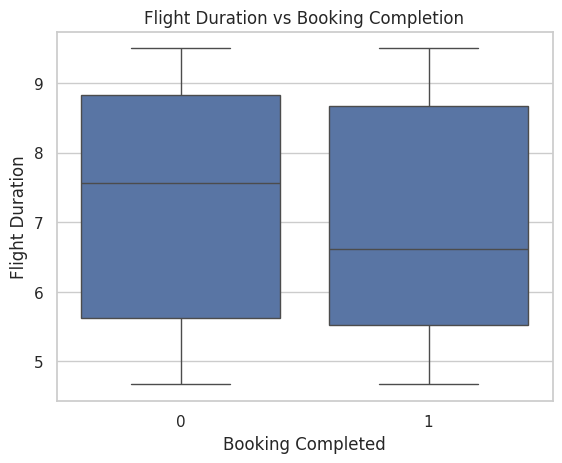

In [91]:
sns.boxplot(x='booking_complete', y='flight_duration', data=df)
plt.title('Flight Duration vs Booking Completion')
plt.xlabel('Booking Completed')
plt.ylabel('Flight Duration')
plt.show()

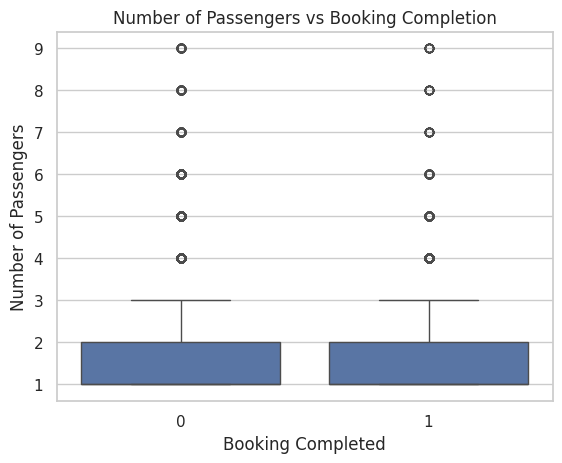

In [92]:
sns.boxplot(x='booking_complete', y='num_passengers', data=df)
plt.title('Number of Passengers vs Booking Completion')
plt.xlabel('Booking Completed')
plt.ylabel('Number of Passengers')
plt.show()

In [93]:
df.booking_complete.value_counts()

,count
booking_complete,
0,41890
1,7391


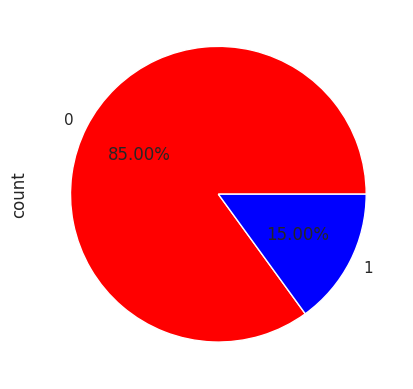

In [94]:
df.booking_complete.value_counts().plot.pie(autopct="%0.2f%%",colors=["red", "blue"])
plt.show()

In [95]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49281 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         49281 non-null  int64  
 1   sales_channel          49281 non-null  object 
 2   trip_type              49281 non-null  object 
 3   purchase_lead          49281 non-null  int64  
 4   length_of_stay         49281 non-null  int64  
 5   flight_hour            49281 non-null  int64  
 6   flight_day             49281 non-null  int64  
 7   route                  49281 non-null  object 
 8   booking_origin         49281 non-null  object 
 9   wants_extra_baggage    49281 non-null  int64  
 10  wants_preferred_seat   49281 non-null  int64  
 11  wants_in_flight_meals  49281 non-null  int64  
 12  flight_duration        49281 non-null  float64
 13  booking_complete       49281 non-null  int64  
dtypes: float64(1), int64(9), object(4)
memory usage: 5.6+ MB


#Data Transformation


In [96]:
categorical_columns = ['sales_channel', 'trip_type', 'route', 'booking_origin']

label_encoders = {}

for col in categorical_columns:
    label_encoders[col] = LabelEncoder()
    df[col] = label_encoders[col].fit_transform(df[col])


print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 49281 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         49281 non-null  int64  
 1   sales_channel          49281 non-null  int64  
 2   trip_type              49281 non-null  int64  
 3   purchase_lead          49281 non-null  int64  
 4   length_of_stay         49281 non-null  int64  
 5   flight_hour            49281 non-null  int64  
 6   flight_day             49281 non-null  int64  
 7   route                  49281 non-null  int64  
 8   booking_origin         49281 non-null  int64  
 9   wants_extra_baggage    49281 non-null  int64  
 10  wants_preferred_seat   49281 non-null  int64  
 11  wants_in_flight_meals  49281 non-null  int64  
 12  flight_duration        49281 non-null  float64
 13  booking_complete       49281 non-null  int64  
dtypes: float64(1), int64(13)
memory usage: 5.6 MB
None


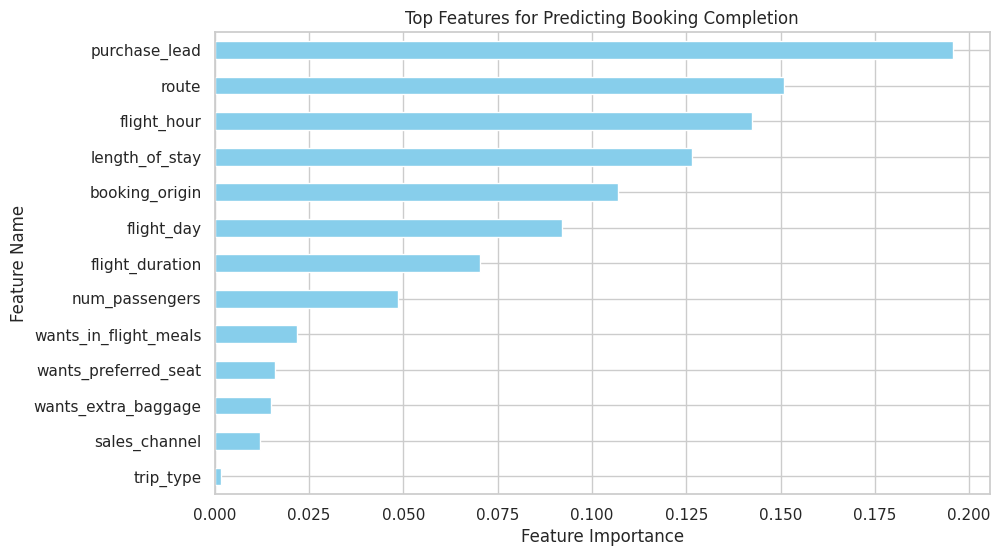

In [97]:
X = df.drop('booking_complete', axis=1)
y = df['booking_complete']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y = y

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X, y)

importances = pd.Series(model.feature_importances_, index=X.columns)
top_features = importances.sort_values(ascending=False).head(15)

plt.figure(figsize=(10,6))
top_features.plot(kind='barh', color='skyblue')
plt.gca().invert_yaxis()
plt.title('Top Features for Predicting Booking Completion')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.show()

# Data Cleaning

In [98]:
df.drop(["wants_in_flight_meals","wants_preferred_seat","wants_extra_baggage",
         "sales_channel","trip_type"],axis = 1 ,inplace = True)
df.columns

Index(['num_passengers', 'purchase_lead', 'length_of_stay', 'flight_hour',
       'flight_day', 'route', 'booking_origin', 'flight_duration',
       'booking_complete'],
      dtype='object')

# Data Processing

In [99]:
X = df.drop(columns=['booking_complete'])
y = df['booking_complete']

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print(y_resampled.value_counts())

booking_complete
0    41890
1    41890
Name: count, dtype: int64


# Create Model

In [100]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.30, random_state=43,
                                                    shuffle = True)

In [101]:
model1 = LogisticRegression()
model2 = GaussianNB()
model3 = MLPClassifier()
model4 = RandomForestClassifier()
model5 = DecisionTreeClassifier()
model6 = GradientBoostingClassifier()
model7 = XGBClassifier()

In [102]:
accuracies = []

def all(model):
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_pred,y_test)
    print("accuracy =",accuracy)
    accuracies.append(accuracy)

all(model1)
all(model2)
all(model3)
all(model4)
all(model5)
all(model6)
all(model7)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


accuracy = 0.6125964828519137
accuracy = 0.6458582000477441
accuracy = 0.6631654332776319
accuracy = 0.8749502665711785
accuracy = 0.815548659186759
accuracy = 0.7754834089281452
accuracy = 0.8289170048539827


In [103]:
algorithms = ["LogisticRegression","GaussianNB","MLPClassifier","RandomForestClassifier"," DecisionTreeClassifier","GradientBoostingClassifier","XGBClassifier"]
results = pd.DataFrame({"algorithms":algorithms,"accuracies":accuracies})
results

,algorithms,accuracies
0,LogisticRegression,0.612596
1,GaussianNB,0.645858
2,MLPClassifier,0.663165
3,RandomForestClassifier,0.874950
4,DecisionTreeClassifier,0.815549
5,GradientBoostingClassifier,0.775483
6,XGBClassifier,0.828917


In [104]:
modelx = XGBClassifier()
modelx.fit(X_train,y_train)
pred = modelx.predict(X_test)
print(modelx.score(X_test,y_test))
print(modelx.score(X_train,y_train))

0.8289170048539827
0.8644579340449476


In [105]:
acc = accuracy_score(y_test, pred)
print(f'Accuracy: {acc}')

Accuracy: 0.8289170048539827


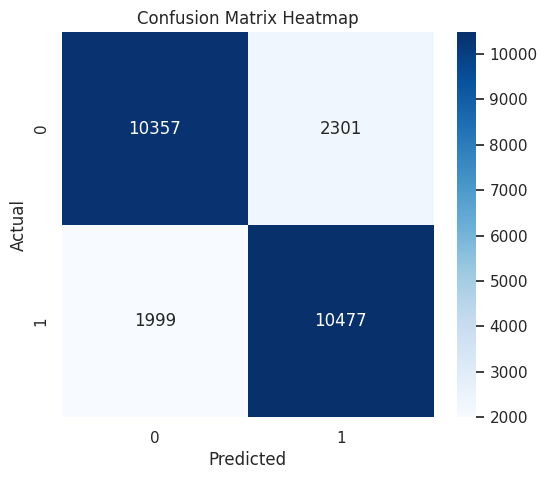

In [106]:
cm = confusion_matrix(y_test, pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()

In [107]:
cr = classification_report(y_test, pred)
print(f'Classification Report: \n{cr}')

Classification Report: 
              precision    recall  f1-score   support

           0       0.84      0.82      0.83     12658
           1       0.82      0.84      0.83     12476

    accuracy                           0.83     25134
   macro avg       0.83      0.83      0.83     25134
weighted avg       0.83      0.83      0.83     25134



In [108]:
import pickle

with open("model.pkl", "wb") as f:
    pickle.dump(modelx, f)